In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/DL/project

/content/drive/.shortcut-targets-by-id/14ZmKa8dpttySIWLAiJVeEcsIXpQejE6C/project


In [ ]:
import os
import torch
import torchvision
import gc

import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from random import sample
from torchsummary import summary
from torch.utils.data import Dataset, Subset
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import f1_score

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [ ]:
colon_dataset = 'lung_colon_image_set/colon_image_sets/'

In [ ]:
transforms_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Resize((64,64)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

transforms_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64,64)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

In [ ]:
dataset = ImageFolder(colon_dataset)

In [ ]:
train_set = CustomDataset(dataset,transforms_train)
val_set = CustomDataset(dataset,transforms_test)
test_set = CustomDataset(dataset,transforms_test)

# Create the index splits for training, validation and test
train_size = 0.8
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_set, indices=train_idx)
val_data = Subset(val_set, indices=valid_idx)
test_data = Subset(test_set, indices=test_idx)

In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*4*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def get_model():
    return ResNet(BasicBlock, [4, 4, 3], 2)

In [ ]:
# create model object, initialize loss and optimizer
net = get_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# model summary to see number of trainable parameters
summary(net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
def train():
  """Training loop
  """
  train_acc = []
  train_loss = 0.0
  correct = 0
  total = 0

  net.train()
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = net(images)
    fit = criterion(outputs, labels)
    fit.backward()
    nn.utils.clip_grad_value_(net.parameters(), clip_value=0.1)
    optimizer.step()
    train_loss += fit.item()
    
    # accuracy
    _, pred = outputs.max(1)
    total += labels.size(0)
    correct += (pred == labels).sum()

    torch.cuda.empty_cache()
    gc.collect()

  loss = train_loss / len(train_loader)
  acc = float(correct)/float(total)

  print(f'Training loss: {loss}, Training acc: {acc}')

  return loss

def validate():
  """Validation loop
  """
  global best_loss
  val_acc = []
  val_loss = 0.0
  correct = 0
  total = 0

  net.eval()
  torch.cuda.empty_cache()
  gc.collect()
  for i, (images, labels) in enumerate(val_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = net(images)
    fit = criterion(outputs, labels)
    val_loss += fit.item()

    # accuracy
    _, pred = outputs.max(1)
    total += labels.size(0)
    correct += (pred == labels).sum()

    torch.cuda.empty_cache()
    gc.collect()

  loss = val_loss / len(val_loader)
  acc = float(correct)/float(total)

  print(f'Validation loss: {loss}, Validation acc: {acc}')

  return loss

In [ ]:
# driver cell to run train and validation methods
epochs = 5
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
  print(f'Epoch {epoch}:')
  train_loss_history.append(train())
  val_loss_history.append(validate())
  # scheduler.step()
  print(f'*'*10)

Epoch 0:
Training loss: 0.21152889943122863, Training acc: 0.915
Validation loss: 0.318841646425426, Validation acc: 0.858
**********
Epoch 1:
Training loss: 0.09063916289806366, Training acc: 0.96575
Validation loss: 0.2632049878593534, Validation acc: 0.908
**********
Epoch 2:
Training loss: 0.06467093305662275, Training acc: 0.975625
Validation loss: 0.07327205740148202, Validation acc: 0.977
**********
Epoch 3:
Training loss: 0.02442814170080237, Training acc: 0.99
Validation loss: 0.035467729467200115, Validation acc: 0.988
**********
Epoch 4:
Training loss: 0.030167194199282675, Training acc: 0.988125
Validation loss: 0.026945229910779744, Validation acc: 0.989
**********


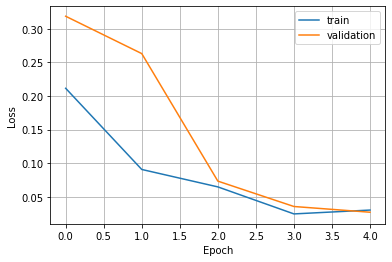

In [ ]:
# train-val loss curves
plt.plot(range(epochs), train_loss_history, '-', label="train")
plt.plot(range(epochs), val_loss_history, '-', label="validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig("resnet_colon.jpg")

In [ ]:
# test accuracy
correct = 0
samples = 0
f1 = []
with torch.no_grad():
  for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)

    scores = net(images)
    _, pred = scores.max(1)
    f1.append(f1_score(labels.cpu(), pred.cpu()))
    correct += (pred == labels).sum()
    samples += pred.size(0)

  acc = float(correct)/float(samples)
  print(f'Test accuracy: {acc}')
  print(f'Test F1 score: {sum(f1)/len(f1)}')

Test accuracy: 0.985
Test F1 score: 0.9818637868868537
